## Loading Data

In [1]:
# read Fashion MNist dataset
from tensorflow import keras

(data_train, out_train), (data_test, out_test) = keras.datasets.fashion_mnist.load_data()
data_train.shape, out_train.shape, data_test.shape, out_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [2]:
# show the tensor of our training image
import matplotlib.pyplot as plt
import numpy as np

print(data_train[0].shape) # check the dimension of one image
print(data_train[0])

(28, 28)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 2

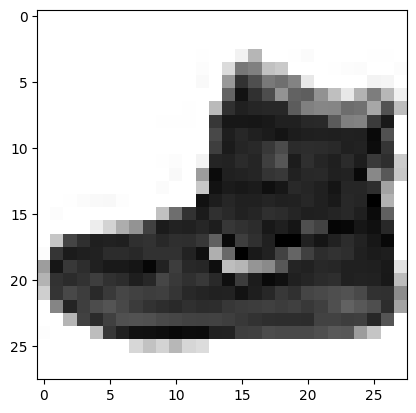

In [3]:
# show the image in orginbal pixel foramt
plt.imshow(data_train[0], cmap=plt.cm.binary)

## Preprocessing

Before we train our data with the deep learnig model, we need to take some steps and transform the training data:

1.  **Normalizing the pixel values between 0 and 1**

  In an image, each pixel value represents the intensity of light at that point. By normolizing the pixel value to 0 and 1, now we can interpret each value as a probability that the pixel belongs to a certain class (e.g., if the pixel value is 0.8, it can be interpreted as an 80% probability that the pixel belongs to the class associated with that intensity)

  This interpretation aligns well with how neural networks often use activation functions like softmax in the output layer, which outputs probabilities representing the likelihood of each class.

2. **Flattening the input arrays into a single vector**

  In neural network architectures, the model expect input data to be in the form of a flat vector rather than a multi-dimensional array. This transformation is essential for feeding the data into fully connected layers, which expect inputs in a flat format. By flattening the input data, we simplify its representation, making it compatible with the network's structure and improving computational efficiency.

In [4]:
# trnasformation --> why do we need to normalize
in_train = keras.utils.normalize(data_train, axis=1)
in_test = keras.utils.normalize(data_test, axis=1)

In [5]:
in_train.min(), in_train.max(), in_test.min(), in_test.max()

(0.0, 1.0, 0.0, 1.0)

Now we make sure our traning parameters are in good shape, we also need to deal with our target variable, which is the category of clothes we want to classify. First, let's take a look of the output:

In [6]:
out_train[0]

9

In [7]:
np.unique(out_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

It seems like the target variable, which is the clothes category, is using number as decoding. We might want to make a decoding dictionary so later we can reference our prediction.

In [8]:
# enumerate our classes
class_names = {
  0: 'T-shirt/top',
  1: 'Trouser',
  2: 'Pullover',
  3: 'Dress',
  4: 'Coat',
  5: 'Sandal',
  6: 'Shirt',
  7: 'Sneaker',
  8: 'Bag',
  9: 'Ankle boot'}

print(class_names)

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


Since our ultimate goal is to deploy this application in scale, perhaps we can create our own interaction dashboard in which users can have a clear view of the training data and their predction.

How many rows of training images would you like to review? 3


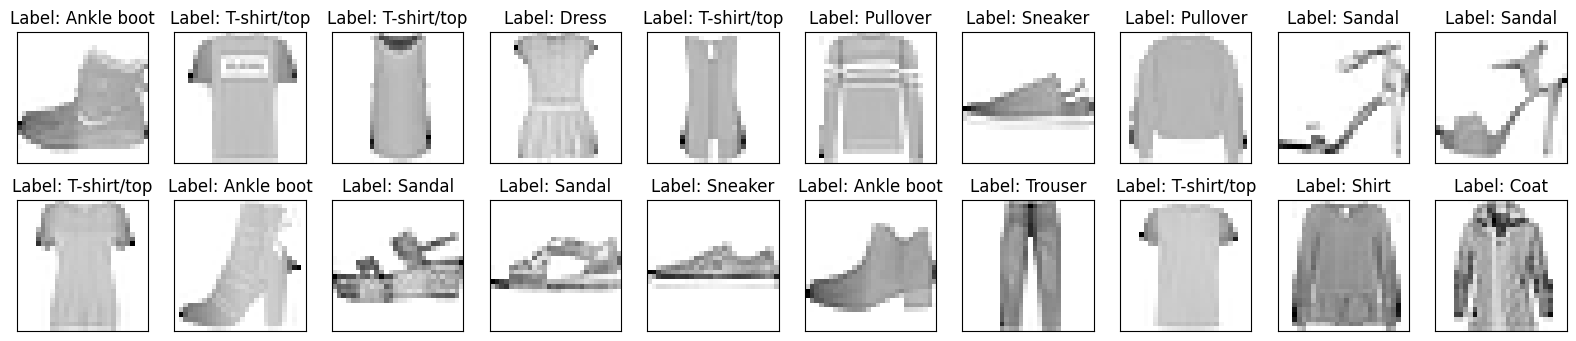

In [9]:
# create a grid of images along with their corresponding labels and predictions.'''
import math
import matplotlib.pyplot as plt

def plot(images, labels, preds=None):
    '''Prompt the user how many rows they would like to see for the trainging images
  and output corresponding number of rows with ten images on each row.'''

    # Prompt the user to input the number of rows they want to see
    rows = int(input('How many rows of training images would you like to review? '))

    n_cols = min(10, len(images))  # The maximum number of columns should not exceed 10
    n_rows = math.ceil(len(images) / n_cols)

    # Adjust the number of rows based on user input
    n_rows = min(rows, n_rows)

    # Adjust the number of images to display based on the available images and requested rows
    num_images = n_rows * n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols + 10, n_rows + 2))

    # Initialize predictions properly based on whether preds is None or not
    predictions = preds if preds is not None else [None] * len(labels)

    for index, (image, label, label_pred) in enumerate(zip(images[:num_images], labels[:num_images], predictions[:num_images])):
        ax = axes.flat[index]
        ax.imshow(image, cmap=plt.cm.binary)
        ax.set_xticks([])
        ax.set_yticks([])
        if label_pred is not None:
            ax.set_title(f"Label: {class_names[label]}, Pred: {class_names[label_pred]}")
        else:
            ax.set_title(f"Label: {class_names[label]}")


plot(in_train[:20], out_train[:20])  # Example: Displaying images with default number of 20 images

## Model Building

Let's first build our model with:

1. One imput layer
2. One hidden later (500 units)
3. One output layer

We will use:

1.  **sigmoid** as our activation function
2.  **sparse_categorical_crossentropy** as our loss function
3.  **sgd** (Stochastic Gradient Descent) as our optimizer
4.  **epoch=5** for a quick start

*Note1: sparse_categorical_crossentropy is the loss function used for a multi-class classification problem with integer labels.*


*Note2: The "stochastic" part comes from the fact that instead of computing the gradient using the entire dataset, it computes it using a randomly selected subset of the data at each iteration, which makes it more computationally efficient and often helps escape local minima.*

In [10]:
model1 = keras.Sequential(layers=[
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(units=500, activation='sigmoid'),
    keras.layers.Dense(units=10, activation='softmax')
    ])

In [11]:
model1.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
model1.fit(in_train,
           out_train,
           batch_size=60, # how often we update the weight change to our model
           epochs=5, # how many times will we use our dataset to train again and again
           validation_split=0.2)

Epoch 1/5
800/800 [==============================] - 10s 11ms/step - loss: 2.0732 - accuracy: 0.4093 - val_loss: 1.8425 - val_accuracy: 0.4886
Epoch 2/5
800/800 [==============================] - 5s 6ms/step - loss: 1.6341 - accuracy: 0.5829 - val_loss: 1.4456 - val_accuracy: 0.6636
Epoch 3/5
800/800 [==============================] - 4s 5ms/step - loss: 1.3160 - accuracy: 0.6407 - val_loss: 1.1966 - val_accuracy: 0.6758
Epoch 4/5
800/800 [==============================] - 5s 6ms/step - loss: 1.1218 - accuracy: 0.6758 - val_loss: 1.0452 - val_accuracy: 0.6925
Epoch 5/5
800/800 [==============================] - 5s 6ms/step - loss: 1.0000 - accuracy: 0.6980 - val_loss: 0.9475 - val_accuracy: 0.7031


Hmm, it seems like our model is just doing ok for now. Let's see if we can make it better by tunning the following parameters:



*   the number of layers
*   the units within each layer
*   the optimizer
*   the loss function
*   the epoch (run time)



## Model Tunning

First let's try to add one more layer to our model and see what would happen.

In [13]:
model2 = keras.Sequential(layers=[
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(units=500, activation='sigmoid'),
    keras.layers.Dense(units=500, activation='sigmoid'),
    keras.layers.Dense(units=10, activation='softmax')
    ])

model2.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model2.fit(in_train,
           out_train,
           batch_size=60, # how often we update the weight change to our model
           epochs=5, # how many times will we use our dataset to train again and again
           validation_split=0.2)

Epoch 1/5
800/800 [==============================] - 8s 9ms/step - loss: 2.2860 - accuracy: 0.1458 - val_loss: 2.2594 - val_accuracy: 0.2915
Epoch 2/5
800/800 [==============================] - 8s 10ms/step - loss: 2.2314 - accuracy: 0.2544 - val_loss: 2.1897 - val_accuracy: 0.3747
Epoch 3/5
800/800 [==============================] - 7s 8ms/step - loss: 2.1303 - accuracy: 0.3580 - val_loss: 2.0499 - val_accuracy: 0.4384
Epoch 4/5
800/800 [==============================] - 8s 10ms/step - loss: 1.9355 - accuracy: 0.4493 - val_loss: 1.8093 - val_accuracy: 0.4760
Epoch 5/5
800/800 [==============================] - 7s 9ms/step - loss: 1.6897 - accuracy: 0.5019 - val_loss: 1.5812 - val_accuracy: 0.5337


There isn't a significant impact -- because this is relatively simple data.

In fact, it even lower our model accuracy. Perhaps for more complex data (e.g., color images for classification), extra layers are more necessary.

What about running more times? Let's see what happen?

In [14]:
model3 = keras.Sequential(layers=[
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(units=500, activation='sigmoid'),
    keras.layers.Dense(units=10, activation='softmax')
    ])

model3.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model3.fit(in_train,
           out_train,
           batch_size=60, # how often we update the weight change to our model
           epochs=10, # how many times will we use our dataset to train again and again
           validation_split=0.2)

Epoch 1/10
800/800 [==============================] - 5s 6ms/step - loss: 2.0674 - accuracy: 0.4105 - val_loss: 1.8341 - val_accuracy: 0.5972
Epoch 2/10
800/800 [==============================] - 5s 7ms/step - loss: 1.6255 - accuracy: 0.5903 - val_loss: 1.4411 - val_accuracy: 0.5617
Epoch 3/10
800/800 [==============================] - 5s 6ms/step - loss: 1.3089 - accuracy: 0.6452 - val_loss: 1.1934 - val_accuracy: 0.6406
Epoch 4/10
800/800 [==============================] - 5s 6ms/step - loss: 1.1172 - accuracy: 0.6789 - val_loss: 1.0453 - val_accuracy: 0.6684
Epoch 5/10
800/800 [==============================] - 5s 7ms/step - loss: 0.9965 - accuracy: 0.6984 - val_loss: 0.9444 - val_accuracy: 0.7083
Epoch 6/10
800/800 [==============================] - 4s 5ms/step - loss: 0.9151 - accuracy: 0.7111 - val_loss: 0.8744 - val_accuracy: 0.7255
Epoch 7/10
800/800 [==============================] - 6s 8ms/step - loss: 0.8559 - accuracy: 0.7216 - val_loss: 0.8230 - val_accuracy: 0.7362
Epoch 

It seems like we are making some progress here!

Since epochs allows our model to see the training data more times, it enables our neurons to learn more complex patterns. **With more epochs, the model has more opportunities to adjust its parameters (weights and biases) based on the training data; therefore, improving our model performance.**

**However, increasing the number of epochs too much can lead to overfitting, where the model learns to memorize the training data rather than generalize to unseen data.** To prevent overfitting, it's important to monitor our model's performance on a separate validation dataset and stop training when the performance starts to degrade.

But before we jump into our model evaluation, let's try and see if different optimizer will affect our model performace.

In [15]:
model4 = keras.Sequential(layers=[
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(units=500, activation='sigmoid'),
    keras.layers.Dense(units=500, activation='sigmoid'),
    keras.layers.Dense(units=10, activation='softmax')
    ])

model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model4.fit(in_train,
           out_train,
           batch_size=60, # how often we update the weight change to our model
           epochs=10, # how many times will we use our dataset to train again and again
           validation_split=0.2)

Epoch 1/10
800/800 [==============================] - 15s 18ms/step - loss: 0.6737 - accuracy: 0.7525 - val_loss: 0.4733 - val_accuracy: 0.8291
Epoch 2/10
800/800 [==============================] - 18s 22ms/step - loss: 0.4429 - accuracy: 0.8391 - val_loss: 0.4040 - val_accuracy: 0.8534
Epoch 3/10
800/800 [==============================] - 11s 14ms/step - loss: 0.4018 - accuracy: 0.8529 - val_loss: 0.3982 - val_accuracy: 0.8546
Epoch 4/10
800/800 [==============================] - 10s 12ms/step - loss: 0.3730 - accuracy: 0.8641 - val_loss: 0.3829 - val_accuracy: 0.8605
Epoch 5/10
800/800 [==============================] - 10s 12ms/step - loss: 0.3540 - accuracy: 0.8699 - val_loss: 0.3667 - val_accuracy: 0.8662
Epoch 6/10
800/800 [==============================] - 9s 11ms/step - loss: 0.3367 - accuracy: 0.8754 - val_loss: 0.4116 - val_accuracy: 0.8466
Epoch 7/10
800/800 [==============================] - 10s 12ms/step - loss: 0.3217 - accuracy: 0.8803 - val_loss: 0.3428 - val_accuracy: 

That's even a bigger progress on our model accuracy!

The Adaptive Learning Rates (also known as 'adam') adapts the learning rates of each parameter during training. **It maintains a separate learning rate for each parameter and adjusts these rates based on the estimated first and second moments of the gradients.** This adaptiveness helps in speeding up convergence and handling different scales of gradients. Therefore, providing a better learning result.

## Model Validation

One of the important metrics we can use to evaluate our model's accuracy is the confusion matrix. It helps us understand how well our model performs when classifying true labels.

Based on this, let's create a confusion matrix function to compare all correct classifications and misclassifications. We'll use this to determine which model performs the best.

313/313 [==============================] - 1s 3ms/step


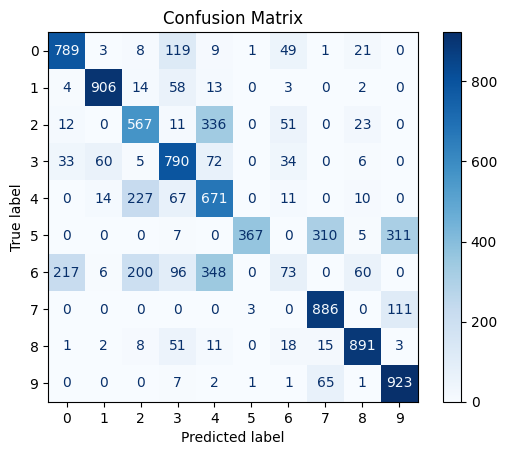

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def report_performance_metrics(model, in_test, out_test):
    '''Report performance metrics on the test set.'''

    # Calculate porbability distribution for each category classification
    probs = model.predict(in_test)
    # Predict labels on the test set
    preds = probs.argmax(axis=1)

    # Create confusion matrix
    cm = confusion_matrix(out_test, preds)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(out_test))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    return probs, preds

probs1, preds1= report_performance_metrics(model1, in_test, out_test)

313/313 [==============================] - 1s 3ms/step


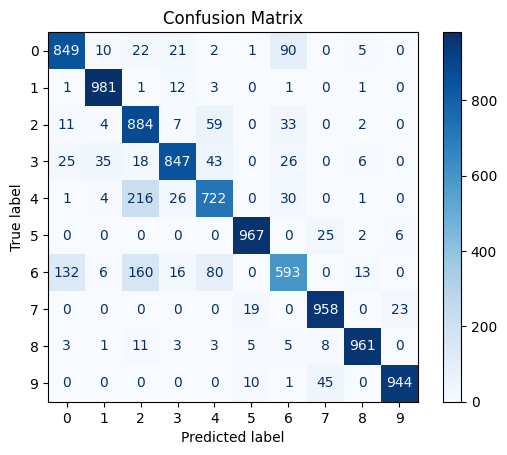

In [17]:
probs4, preds4 = report_performance_metrics(model4, in_test, out_test)

We can observe that from model1 to model4, our true positive rate has increased substantially. As the color of the tangent becomes darker, we can infer that our model is learning better.

## Browser Application

Numbers and figures can sometimes be overwhelming. Since we have our prediction labels and corresponding probabilities, let's try to create an interactive dashboard where users can reference both the original classification label and our prediction result.

interactive(children=(IntSlider(value=0, description='Image Index', layout=Layout(width='100%'), max=9999), Ou…

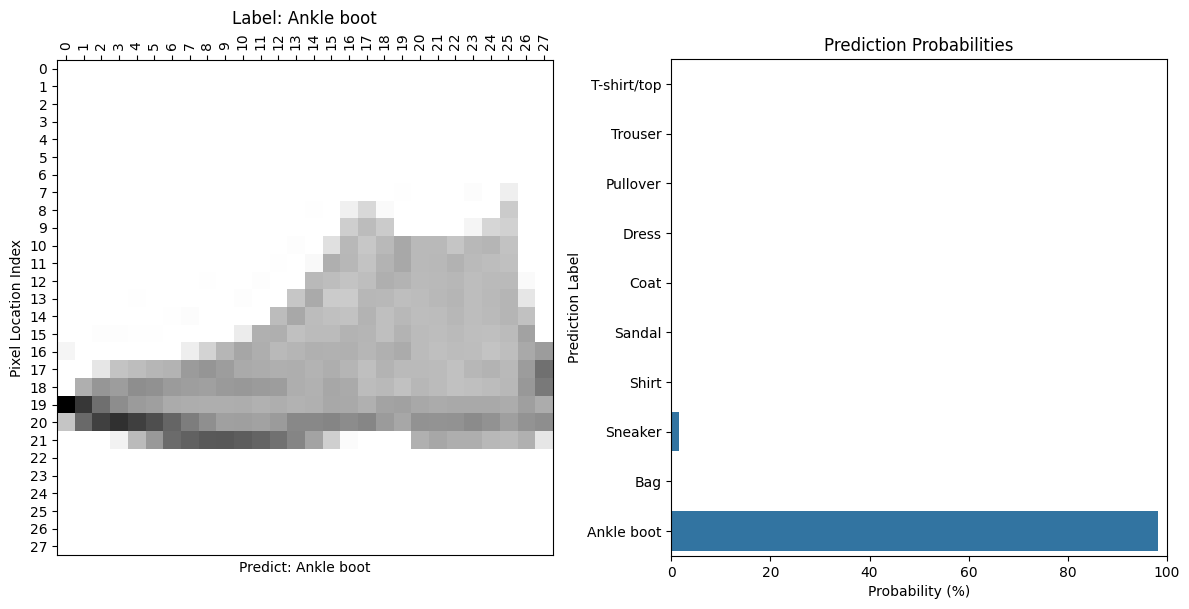

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import widgets, interact, Layout

# Assuming preds, probs, in_test, out_test, class_names are defined elsewhere

img_idx_slider = widgets.IntSlider(value=0, min=0, max=len(in_test) - 1,
                                   description='Image Index',
                                   layout=Layout(width='100%'))

@interact(index=img_idx_slider)
def visualize_prediction(index=0):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(in_test[index], cmap=plt.cm.binary)
    ax1.set_title(f'Label: {class_names[out_test[index]]}')
    ax1.xaxis.tick_top()
    ax1.set_xlabel(f'Predict: {class_names[preds4[index]]}')
    ax1.set_ylabel('Pixel Location Index')
    ax1.set_xticks(range(28))
    ax1.set_yticks(range(28))
    ax1.tick_params(axis='x', labelrotation=90)
    bar = sns.barplot(y=[class_names[ind] for ind in range(10)],
                      x=probs4[index]*100)
    bar.set_xlim(0, 100)
    bar.set_xlabel('Probability (%)')
    bar.set_ylabel('Prediction Label')
    bar.set_title('Prediction Probabilities')
    fig.tight_layout()
    plt.show()

visualize_prediction()


interactive(children=(IntSlider(value=0, description='Image Index', layout=Layout(width='100%'), max=9999), In…

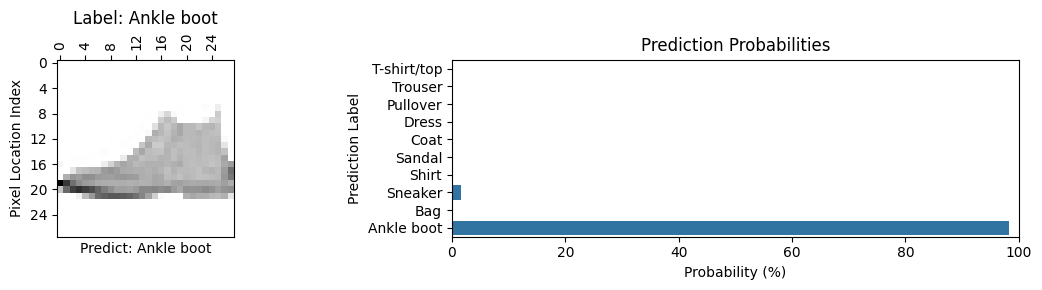

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import widgets, interact, Layout

# Assuming preds4, probs4, in_test, out_test, class_names are defined elsewhere

# Slider for selecting the image index
img_idx_slider = widgets.IntSlider(value=0, min=0, max=len(in_test) - 1,
                                   description='Image Index',
                                   layout=Layout(width='100%'))

# Slider for selecting the number of rows
rows_slider = widgets.IntSlider(value=1, min=1, max=10,
                                description='Rows',
                                layout=Layout(width='100%'))

@interact(index=img_idx_slider, rows=rows_slider)
def visualize_prediction(index=0, rows=1):

    fig, axs = plt.subplots(rows, 2, figsize=(12, rows * 3),
                            gridspec_kw={'width_ratios': [1, 1]})

    # Handling the case of only one row differently
    if rows == 1:
        axs = [axs]

    for i, (ax1, ax2) in enumerate(axs):
        ax1.imshow(in_test[index + i], cmap=plt.cm.binary)
        ax1.set_title(f'Label: {class_names[out_test[index + i]]}')
        ax1.xaxis.tick_top()
        ax1.set_xlabel(f'Predict: {class_names[preds4[index + i]]}')
        ax1.set_ylabel('Pixel Location Index')
        ax1.set_xticks(range(28))
        ax1.set_yticks(range(28))
        # Set fewer tick marks to avoid cramming
        tick_marks = np.arange(0, 28, 4)  # Show a tick every 4 pixels
        ax1.set_xticks(tick_marks)
        ax1.set_yticks(tick_marks)
        ax1.tick_params(axis='x', labelrotation=90)

        bar = sns.barplot(y=[class_names[ind] for ind in range(10)],
                          x=probs4[index + i] * 100, ax=ax2)
        bar.set_xlim(0, 100)
        bar.set_xlabel('Probability (%)')
        bar.set_ylabel('Prediction Label')
        bar.set_title('Prediction Probabilities')

    fig.tight_layout()
    plt.show()

visualize_prediction()
